# MNIST fashion Autoencoder
<center>
<img src="https://www.tensorflow.org/static/tutorials/generative/images/intro_autoencoder_result.png">
</center>

# Import Libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

# Load MNIST Dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


# Data Preprocessing
Reshape to (28, 28, 1) and normalize input images

In [4]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Hyperparameters

In [5]:
input_shape = (image_size, image_size, 1)
batch_size = 8
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build Encoder Model

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


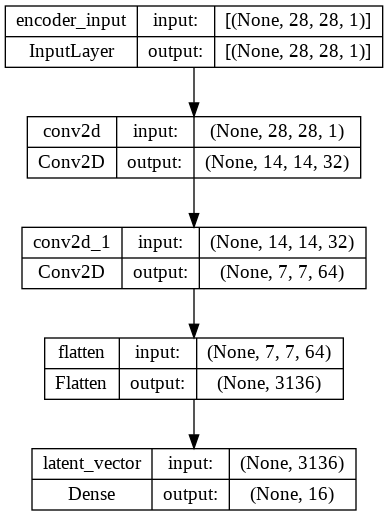

In [7]:
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

# Build Decoder Model

In [8]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

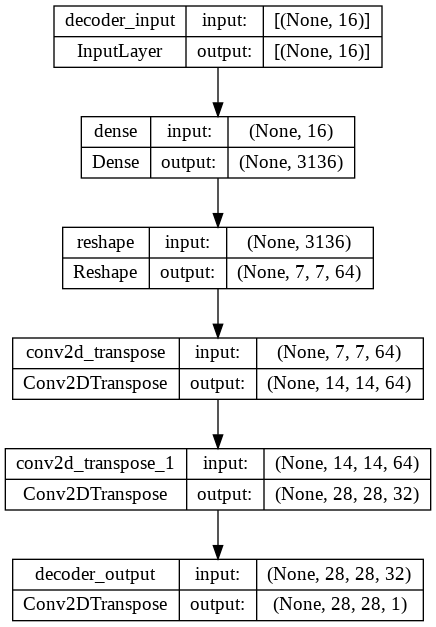

In [9]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

# Autoencoder
Autoencoder = encoder + decoder

In [10]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


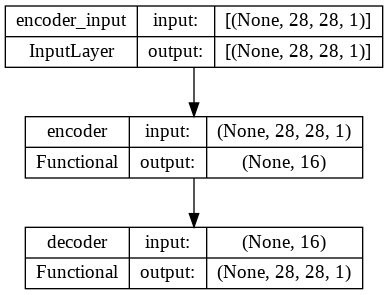

In [11]:
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

In [12]:
autoencoder.compile(loss='mse', optimizer='adam')

# Train the Autoencoder

In [13]:
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=10,
                batch_size=batch_size)

Epoch 1/10
7500/7500 [==============================] - 42s 4ms/step - loss: 0.0151 - val_loss: 0.0118
Epoch 2/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 3/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 4/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 5/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 6/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 7/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 8/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 9/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 10/10
7500/7500 [==============================] - 28s 4ms/step - l

# Results

In [16]:
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Display the 1st 8 test input and decoded images

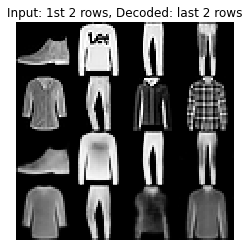

In [17]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()